# Modeling an HHL Algorithm to Solve a Set of Linear Equations

Guidance for the workshop:
**The `# TODO` is there for you to do yourself.**
**The `# Solution start` and `# Solution end` are only for helping you. Try doing it yourself...**

Solving linear equations appears in many research, engineering, and design fields. For example, many physical and financial models, from fluid dynamics to portfolio optimization, are described by partial differential equations, which are typically treated by numerical schemes, most of which are eventually transformed to a set of linear equations.

The HHL algorithm [[1](#HHL)] is a quantum algorithm for solving a set of linear equations. It is one of the fundamental quantum algorithms that is expected to give a speedup over its classical counterpart.


A set of linear equations of size $N$ is represented by an $N\times N$ matrix and a vector $b$ of size $N$, $A\vec{x} = \vec{b}$, where the solution to the problem is designated by the solution variable $\vec{x}$.

For simplicity, the demo below treats a usecase where $\vec{b}$ is a normalized vector $|\vec{b}|=1$, and $A$ is an Hermitian matrix of size $2^n\times 2^n$, whose eigenvalues are in the interval $(0,1)$. Generalizations to other usecases are discussed at the end of this demo.

# 1. Defining a Specific Problem

Start by defining the specific problem.

In [1]:
# !pip install -U classiq

In [2]:
import numpy as np
import scipy as scipy

A = np.array(
    [
        [0.28, -0.01, 0.02, -0.1],
        [-0.01, 0.5, -0.22, -0.07],
        [0.02, -0.22, 0.43, -0.05],
        [-0.1, -0.07, -0.05, 0.42],
    ]
)

b = np.array([1, 2, 4, 3])
b = b / np.linalg.norm(b)

print("A =", A, "\n")
print("b =", b, "\n")

# verifying that the matrix is symmetric and has eigenvalues in [0,1)
if not np.allclose(A, A.T, rtol=1e-6, atol=1e-6):
    raise Exception("The matrix is not symmetric")
w, v = np.linalg.eig(A)
for lam in w:
    if lam < 0 or lam > 1:
        raise Exception("Eigenvalues are not in (0,1)")

sol_classical = np.linalg.solve(A, b)
print("Classical solution: x = ", sol_classical)
num_qubits = int(np.log2(len(b)))

A = [[ 0.28 -0.01  0.02 -0.1 ]
 [-0.01  0.5  -0.22 -0.07]
 [ 0.02 -0.22  0.43 -0.05]
 [-0.1  -0.07 -0.05  0.42]] 

b = [0.18257419 0.36514837 0.73029674 0.54772256] 

Classical solution: x =  [1.3814374  2.50585064 3.19890483 2.43147877]


# 2. Building Simple HHL with Classiq

## 2.1 Define The Model
This tutorial gives instructions on building an HHL algorithm and presents the theory of the algorithm. The algorithm consists of 4 steps:

1) State preparation of the RHS vector $\vec{b}$.

2) QPE for the unitary matrix $e^{2\pi iA}$, which encodes eigenvalues on a quantum register of size $m$.

3) An inversion algorithm that loads amplitudes according to the inverse of the eigenvalue registers.

4) An inverse QPE with the parameters in (2).

### 2.1.1 State Preparation for the Vector $\vec{b}$

The first stage of the HHL algorithm is to load the normalized RHS vector $\vec{b}$ into a quantum register:

$$
|0\rangle_n \xrightarrow[{\rm SP}]{} \sum^{2^n-1}_{i=0}b_i|i\rangle_n
$$

where $|i\rangle$ are states in the computational basis.

Comments:

* The relevant built-in function is the `prepare_amplitudes` one, which gets $2^n$ values of $\vec{b}$, as well as an upper bound for its functional error through the `bound` parameter.

In [3]:
from classiq import *


@qfunc
def load_b(b: CArray[CReal], res: Output[QArray[QBit]]) -> None:
    # TODO prepare the state |b> in the "res" register - the amplitude of res states correspond to the values of the vector b
    # Solution start
    prepare_amplitudes(b, 0.0, res)
    # Solution end

Let's see the loading of b in a state vector simulator

Update the qmod to have `aer_simulator_statevector` as backend, with one shot

Refer to [Execution Preferences documentation](https://docs.classiq.io/latest/reference-manual/executor/#execution-preferences) and to [Classiq backends documentation](https://docs.classiq.io/latest/reference-manual/executor/cloud-providers/)

In [4]:
@qfunc
def main(res: Output[QArray[QBit]]):
    load_b(b.tolist(), res)


from classiq import create_model, execute, show, synthesize
from classiq.execution import ClassiqBackendPreferences, ExecutionPreferences
from classiq.synthesis import set_execution_preferences

qmod_b_load = create_model(main)
# TODO update the qmod to have aer_simulator_statevector as backend, with one shot

# Solution start
backend_preferences = ClassiqBackendPreferences(backend_name="simulator_statevector")
qmod_b_load = set_execution_preferences(
    qmod_b_load,
    execution_preferences=ExecutionPreferences(
        num_shots=1, backend_preferences=backend_preferences
    ),
)
# Solution end
qprog_b_load = synthesize(qmod_b_load)
show(qprog_b_load)

Opening: https://platform.classiq.io/circuit/9c1bb97f-5749-4d3f-851d-814e42ff2d4f?version=0.45.0.dev0%2Bcf1b9b7ccc


Take a look at the resulted circuit.
Now let's execute and see if $b$ was built correctly

In [5]:
job = execute(qprog_b_load)
job.open_in_ide()

Check if you see a match between the original $b$ to the resulted state vector

In [6]:
print("The original b is: ", b)
results = job.result()
res_hhl = results[0].value
print("The resulted state vector :", res_hhl.state_vector)

The original b is:  [0.18257419 0.36514837 0.73029674 0.54772256]


The resulted state vector : {'00': '(-2.8345860869540946e-17+0.18257418583505516j)', '01': '(-1.7166416255049204e-17+0.3651483716701106j)', '10': '(1.1992422539964905e-16+0.7302967433402218j)', '11': '(8.006184267872856e-17+0.547722557505166j)'}


### 2.1.2 Quantum Phase Estimation (QPE) for the Hamiltonian Evolution $U=e^{2\pi i A }$

The QPE function block, which is at the heart of the HHL algorithm, operates as follows: Unitary matrices have eigenvalues of norm 1, and thus are of the form $e^{2\pi i \lambda}$, with $0\leq\lambda<1$. For a quantum state $|\psi\rangle_n$, prepared in an eigenvalue of some unitary matrix $U$ of size $2^n\times 2^n$, the QPE algorithm encodes the corresponding  eigenvalue into a quantum register:

$$
|0\rangle_m|\psi\rangle_n \xrightarrow[{\rm QPE}(U)]{} |\lambda\rangle_m|\psi\rangle_n,
$$

where $m$ is the precision of the binary representation of $\lambda$, $\lambda=\frac{1}{2^m}\sum^{2^m-1}_{k=0}\lambda^{(k)}2^k$ with $\lambda^{(k)}$ being the state of the $k$-th qubit.

In the HHL algorithm a QPE for the unitary $U=e^{2\pi i A }$ is applied. The mathematics: First, note that the eigenvectors of $U$ are the ones of the matrix $A$, and that the corresponding eigenvalues $\lambda$ defined for $U=e^{2\pi i A }$ are the eigenvalues of $A$. Second, represent the prepared state in the basis given by the eigenvalues of $A$. This is merely a mathematical transformation; with no algorithmic considerations here. If the eigenbasis of $A$ is given by the set $\{|\psi_j\rangle_n \}^{2^n-1}_{j=0}$, then

$$
\sum^{2^n-1}_{i=0}b_i|i\rangle_n = \sum^{2^n-1}_{j=0}\beta_j|\psi_j\rangle_n.
$$

Applying the QPE stage gives

$$
|0\rangle_m \sum^{2^n-1}_{j=0}\beta_j|\psi_j\rangle_n \xrightarrow[{\rm QPE}]{}  \sum^{2^n-1}_{j=0}\beta_j |\lambda_j\rangle_m |\psi_j\rangle_n.
$$

Comments:

* Use the built-in `qpe` function.

### 2.1.3 Eigenvalue Inversion
The next step in the HHL algorithm is to pass the inverse of the eigenvalue registers into their amplitudes, using the Amplitude Loading (AL) construct.
Given a function $f:[0,1)\rightarrow [-1,1]$, it implements $|0\rangle|\lambda\rangle_m \xrightarrow[{\rm AL}(f)]{} f(\lambda)|1\rangle|\lambda\rangle_m+\sqrt{1-f^2(\lambda)}|0\rangle|\lambda\rangle_m$. For the HHL algorithm, apply an AL with $f=C/x$ where $C$ is a lower bound for the minimal eigenvalue of $A$.
Applying this AL gives

$$
\sum^{2^n-1}_{j=0}\beta_j |\lambda_j\rangle_m |\psi_j\rangle_n \xrightarrow[{\rm AL}(C/x)]{}
|0\rangle\left(\sum^{2^n-1}_{j=0}\sqrt{1-\frac{C^2}{\lambda^2_j}}\beta_j |\lambda_j\rangle_m |\psi_j\rangle_n\right)+
|1\rangle\left(\sum^{2^n-1}_{j=0}\frac{C}{\lambda_j}\beta_j |\lambda_j\rangle_m |\psi_j\rangle_n\right),
$$

where $C$ is a normalization coefficient.

The normalization coefficient $C$, which guarantees that the amplitudes are normalized, can be taken as the lower possible eigenvalue that can be resolved with the QPE:

$$
C=1/2^{\rm precision}.
$$

The built-in construct to define an amplitude loading is designated by `*=`, see [Expression Assignment Operations](https://docs.classiq.io/latest/reference-manual/qmod/language-reference/statements/numeric-assignment/#example-3-in-place-assignment-of-a-logical-expression).

In [7]:
@qfunc
def simple_eig_inv(phase: QNum, indicator: Output[QBit]):
    # TODO allocate 1 qubit for indicator
    # TODO load its |1> state amplitude to be C/phase using the *= operator

    # Solution start
    allocate(1, indicator)
    indicator *= (1 / 2**phase.size) / phase
    # Solution end

### 2.1.4 Inverse QPE

As the final step in the HHL model, clean the QPE register by applying an inverse-QPE. (Note that it is not guaranteed that this register is completely cleaned; namely, that all the qubits in the QPE register return to zero after the inverse-QPE. Generically they are all zero with very high probability).

In this model we will simply call the QPE function with the same parameters in stage 2. This is how the quantum state looks now

$$
 |0\rangle\left(\sum^{2^n-1}_{j=0}\sqrt{1-\frac{C^2}{\lambda^2_j}}\beta_j |\lambda_j\rangle_m |\psi_j\rangle_n\right)+
|1\rangle\left(\sum^{2^n-1}_{j=0}\frac{C}{\lambda_j}\beta_j |\lambda_j\rangle_m |\psi_j\rangle_n\right)
\xrightarrow[{\rm inv-QPE}(U)]{}
 |0\rangle_m|0\rangle\left(\sum^{2^n-1}_{j=0}\sqrt{1-\frac{C^2}{\lambda^2_j}}\beta_j  |\psi_j\rangle_n\right)+
|0\rangle_m|1\rangle\left(\sum^{2^n-1}_{j=0}\frac{C}{\lambda_j}\beta_j  |\psi_j\rangle_n\right)
$$

The state entangled with $|1\rangle$ stores the solution to our problem (up to some normalization problem)

$$
\sum^{2^n-1}_{j=0} \frac{C}{\lambda_j}\beta_j  \vec{\psi_j} = C\vec{x}.
$$


### 2.1.5 Putting it all together

Let's remind that the entire HHL algorithm is composed of:

1) State preparation of the RHS vector $\vec{b}$.

2) QPE for the unitary matrix $e^{2\pi iA}$, which encodes eigenvalues on a quantum register of size $m$.

3) An inversion algorithm that loads amplitudes according to the inverse of the eigenvalue registers.

4) An inverse QPE with the parameters in (2).

And put all together in `my_hhl` function

You can apply QPE† * EigenValInv * QPE using the [within_apply operator](https://docs.classiq.io/latest/reference-manual/qmod/language-reference/statements/within-apply/)

In [8]:
@qfunc
def my_hhl(
    fraction_digits: CInt,
    b: CArray[CReal],
    unitary_with_matrix: QCallable[QArray[QBit]],
    res: Output[QArray[QBit]],
    phase: Output[QNum],
    indicator: Output[QBit],
) -> None:
    # TODO Call load_b you created, to load "b" vector into register "res"
    # Solution start
    load_b(b, res)
    # Solution end

    # TODO allocate a qnum register for "phase". This qnum should be in the range [0,1) with fraction_digits precision
    # Solution start
    allocate_num(fraction_digits, False, fraction_digits, phase)
    # Solution end

    # TODO refer to applying (QPE†)*(EigenValInv)*(QPE) : we want to apply "simple_eig_inv" within "qpe"
    # Solution start
    within_apply(
        lambda: qpe(unitary=lambda: unitary_with_matrix(res), phase=phase),
        lambda: simple_eig_inv(phase=phase, indicator=indicator),
    )
    # Solution end

The first entry point of any model would be the `main` function.
Since you already have done all the job in `my_hhl` function, all we have to do now is to call it with the relevant inputs

Call `my_hhl` with `QPE_SIZE` digits resolution, on the normalized `b`, where the unitary is based on `unitary_mat`.

In [9]:
QPE_SIZE = 4


@qfunc
def main(res: Output[QNum], phase: Output[QNum], indicator: Output[QBit]):
    b_normalized = b.tolist()
    unitary_mat = scipy.linalg.expm(1j * 2 * np.pi * A).tolist()

    # TODO call my_hhl with QPE_SIZE digits resolution, on the normalized b, where the unitary is based on "unitary_mat"

    # Solution start
    my_hhl(
        fraction_digits=QPE_SIZE,
        b=b_normalized,
        unitary_with_matrix=lambda target: unitary(elements=unitary_mat, target=target),
        res=res,
        phase=phase,
        indicator=indicator,
    )
    # Solution end

## 2.2 Add Execution Preferences
Once we have a model `qmod_hhl` (by creating it from `main`), we would like to add execution details to prepare for the program execution stage.

In [10]:
from classiq.execution import ClassiqBackendPreferences, ExecutionPreferences

backend_preferences = ClassiqBackendPreferences(backend_name="simulator_statevector")

qmod_hhl = create_model(
    entry_point=main,
    execution_preferences=ExecutionPreferences(
        num_shots=1, backend_preferences=backend_preferences
    ),
)

## 2.2 Synthesize - from qmod to qprog
Once we have a high level model, we would like to compile and get the actual quantum program.
This is done using the `synthesize` command.

In [11]:
qprog_hhl = synthesize(qmod_hhl)

Viewing in IDE

In [12]:
show(qprog_hhl)

Opening: https://platform.classiq.io/circuit/bc7813dd-f2a1-44df-b686-5036506258c9?version=0.45.0.dev0%2Bcf1b9b7ccc


Details about `qprog` as depth for example, can be seen both in IDE and in Python SDK

In [13]:
circuit_hhl = QuantumProgram.from_qprog(qprog_hhl)
print("depth = ", circuit_hhl.transpiled_circuit.depth)

depth =  461


In [14]:
print("depth = ", circuit_hhl.transpiled_circuit.get_circuit_metrics())

depth =  depth=461 count_ops={'u': 270, 'cx': 288}


## 2.3 Execution
Here we execute the circuit on state vector simulator (the backend for execution is defined before the synthesis stage).
We can show the results in the IDE and save the state-vector into a variable.

In [15]:
job = execute(qprog_hhl)

In [16]:
job.open_in_ide()

In [17]:
results = job.result()
res_hhl = results[0].value

## 2.4 Post-process
We would like to look at the answers that are encoded in the amplitudes of the terms that their indicator qubit value=1

In [18]:
target_pos = res_hhl.physical_qubits_map["indicator"][0]  # position of control qubit
sol_pos = list(res_hhl.physical_qubits_map["res"])  # position of solution
phase_pos = list(
    res_hhl.physical_qubits_map["phase"]
)  # position of the “phase” register, and flips for endianness as we will use the indices to read directly from the string

Define a run over all the relevant strings holding the solution. The solution vector will be inserted into the variable `qsol`. Factor out $C=1/2^m$.

In [19]:
qsol = [
    np.round(parsed_state.amplitude / (1 / 2**QPE_SIZE), 5)
    for solution in range(2**num_qubits)
    for parsed_state in res_hhl.parsed_state_vector
    if parsed_state["indicator"] == 1.0
    and parsed_state["res"] == solution
    and parsed_state["phase"]
    == 0.0  # this takes the entries where the “phase” register is at state zero
]
print("Quantum Solution: ", np.abs(qsol) / np.linalg.norm(qsol))
print("Classical Solution: ", sol_classical / np.linalg.norm(sol_classical))

Quantum Solution:  [0.28406276 0.50843682 0.64683747 0.49234301]
Classical Solution:  [0.28005009 0.5079953  0.6484938  0.49291836]


In [20]:
fidelity = (
    np.abs(
        np.dot(
            sol_classical / np.linalg.norm(sol_classical),
            qsol / np.linalg.norm(qsol),
        )
    )
    ** 2
)
print("Solution Fidelity:", fidelity)

Solution Fidelity: 0.999980629206406


# 3. Comparing classical and quantum solutions.

Note that the HHL algorithm returns a statevector result up to some global phase (coming from transpilation or from the quantum functions themselves). Therefore, to compare with the classical solution, correct for this global phase.


In [21]:
sol_classical = np.linalg.solve(A, b)
global_phase = np.angle(qsol)
qsol_corrected = np.real(qsol / np.exp(1j * global_phase))
print("classical:  ", sol_classical)
print("HHL:        ", qsol_corrected)
print(
    "relative distance:  ",
    round(
        np.linalg.norm(sol_classical - qsol_corrected)
        / np.linalg.norm(sol_classical)
        * 100,
        1,
    ),
    "%",
)

classical:   [1.3814374  2.50585064 3.19890483 2.43147877]
HHL:         [1.43558902 2.56952486 3.26897048 2.48819039]
relative distance:   2.5 %


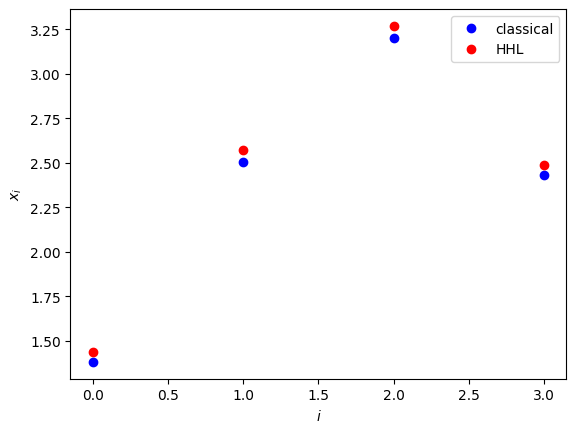

In [22]:
import matplotlib.pyplot as plt

plt.plot(sol_classical, "bo", label="classical")
plt.plot(qsol_corrected, "ro", label="HHL")
plt.legend()
plt.xlabel("$i$")
plt.ylabel("$x_i$")
plt.show()

# 4. Generalizations

The usecase treated above is a canonical one, assuming the following properties:

1) The RHS vector $\vec{b}$ is normalized.

2) The matrix $A$ is an Hermitian one.

3) The matrix $A$ is of size $2^n\times 2^n $.

4) The eigenvalues of $A$ are in the range $(0,1)$.

However, any general problem that does not follow these conditions can be resolved as follows:

1) As preprocessing, normalize $\vec{b}$ and then return the normalization factor as a post-processing

2) Symmetrize the problem as follows:

$$
\begin{pmatrix}
0 & A^T \\
A & 0
\end{pmatrix}
\begin{pmatrix}
\vec{b}  \\
0
\end{pmatrix}
=
\begin{pmatrix}
0  \\
\vec{x}
\end{pmatrix}.
$$

This increases the number of qubits by 1.

3) Complete the matrix dimension to the closest $2^n$ with an identity matrix. The vector $\vec{b}$ will be completed with zeros.

$$
\begin{pmatrix}
A & 0 \\
0 & I
\end{pmatrix}
\begin{pmatrix}
\vec{b}  \\
0
\end{pmatrix}
=
\begin{pmatrix}
\vec{x}  \\
0
\end{pmatrix}.
$$

4) If the eigenvalues of $A$ are in the range $[-w_{\min},w_{\max}]$ you can employ transformations to the exponentiated matrix that enters into the Hamiltonian simulation, and then undo them for extracting the results:

$$
\tilde{A}=(A+w_{\min}I)\left(1-\frac{1}{2^{m}}\right)\frac{1}{w_{\min}+w_{\max}}.
$$

The eigenvalues of this matrix lie in the interval $[0,1)$, and are related to the eigenvalues of the original matrix via

$$
\lambda = (w_{\min}+w_{\max})\tilde{\lambda}\left[1/\left(1-\frac{1}{2^{n_{m}}}\right)\right]-w_{\min},
$$

with $\tilde{\lambda}$ being an eigenvalue of $\tilde{A}$ resulting from the QPE algorithm. This relation between eigenvalues is then used for the expression inserted into the eigenvalue inversion, via the `AmplitudeLoading` function.

## References

<a name='HHL'>[1]</a>: [Harrow, A. W., Hassidim, A., & Lloyd, S., Quantum Algorithm for Linear Systems of Equations. Physical Review Letters 103, 150502 (2009)](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.103.150502).
